In [1]:
import logging
import os

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)


class FunsdDataset(Dataset):
    def __init__(self, args, tokenizer, labels, pad_token_label_id, mode):
        if args.local_rank not in [-1, 0] and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        # Load data features from cache or dataset file
        cached_features_file = os.path.join(
            args.data_dir,
            "cached_{}_{}_{}".format(
                mode,
                list(filter(None, args.model_name_or_path.split("/"))).pop(),
                str(args.max_seq_length),
            ),
        )
        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            features = torch.load(cached_features_file)
        else:
            logger.info("Creating features from dataset file at %s", args.data_dir)
            examples = read_examples_from_file(args.data_dir, mode)
            features = convert_examples_to_features(
                examples,
                labels,
                args.max_seq_length,
                tokenizer,
                cls_token_at_end=bool(args.model_type in ["xlnet"]),
                # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args.model_type in ["xlnet"] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args.model_type in ["roberta"]),
                # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args.model_type in ["xlnet"]),
                # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args.model_type in ["xlnet"] else 0,
                pad_token_label_id=pad_token_label_id,
            )
            if args.local_rank in [-1, 0]:
                logger.info("Saving features into cached file %s", cached_features_file)
                torch.save(features, cached_features_file)

        if args.local_rank == 0 and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        self.features = features
        # Convert to Tensors and build dataset
        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_segment_ids = torch.tensor(
            [f.segment_ids for f in features], dtype=torch.long
        )
        self.all_label_ids = torch.tensor(
            [f.label_ids for f in features], dtype=torch.long
        )
        self.all_bboxes = torch.tensor([f.boxes for f in features], dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return (
            self.all_input_ids[index],
            self.all_input_mask[index],
            self.all_segment_ids[index],
            self.all_label_ids[index],
            self.all_bboxes[index],
        )


class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels, boxes, actual_bboxes, file_name, page_size):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(
        self,
        input_ids,
        input_mask,
        segment_ids,
        label_ids,
        boxes,
        actual_bboxes,
        file_name,
        page_size,
    ):
        assert (
            0 <= all(boxes) <= 1000
        ), "Error with input bbox ({}): the coordinate value is not between 0 and 1000".format(
            boxes
        )
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    box_file_path = os.path.join(data_dir, "{}_box.txt".format(mode))
    image_file_path = os.path.join(data_dir, "{}_image.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f, open(
        box_file_path, encoding="utf-8"
    ) as fb, open(image_file_path, encoding="utf-8") as fi:
        words = []
        boxes = []
        actual_bboxes = []
        file_name = None
        page_size = None
        labels = []
        for line, bline, iline in zip(f, fb, fi):
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(
                        InputExample(
                            guid="{}-{}".format(mode, guid_index),
                            words=words,
                            labels=labels,
                            boxes=boxes,
                            actual_bboxes=actual_bboxes,
                            file_name=file_name,
                            page_size=page_size,
                        )
                    )
                    guid_index += 1
                    words = []
                    boxes = []
                    actual_bboxes = []
                    file_name = None
                    page_size = None
                    labels = []
            else:
                splits = line.split("\t")
                bsplits = bline.split("\t")
                isplits = iline.split("\t")
                assert len(splits) == 2
                assert len(bsplits) == 2
                assert len(isplits) == 4
                assert splits[0] == bsplits[0]
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                    box = bsplits[-1].replace("\n", "")
                    box = [int(b) for b in box.split()]
                    boxes.append(box)
                    actual_bbox = [int(b) for b in isplits[1].split()]
                    actual_bboxes.append(actual_bbox)
                    page_size = [int(i) for i in isplits[2].split()]
                    file_name = isplits[3].strip()
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(
                InputExample(
                    guid="%s-%d".format(mode, guid_index),
                    words=words,
                    labels=labels,
                    boxes=boxes,
                    actual_bboxes=actual_bboxes,
                    file_name=file_name,
                    page_size=page_size,
                )
            )
    return examples


def convert_examples_to_features(
    examples,
    label_list,
    max_seq_length,
    tokenizer,
    cls_token_at_end=False,
    cls_token="[CLS]",
    cls_token_segment_id=1,
    sep_token="[SEP]",
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    cls_token_box=[0, 0, 0, 0],
    sep_token_box=[1000, 1000, 1000, 1000],
    pad_token_box=[0, 0, 0, 0],
    pad_token_segment_id=0,
    pad_token_label_id=-1,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        file_name = example.file_name
        page_size = example.page_size
        width, height = page_size
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        token_boxes = []
        actual_bboxes = []
        label_ids = []
        for word, label, box, actual_bbox in zip(
            example.words, example.labels, example.boxes, example.actual_bboxes
        ):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))
            actual_bboxes.extend([actual_bbox] * len(word_tokens))
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend(
                [label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1)
            )

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
            actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
            label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        token_boxes += [sep_token_box]
        actual_bboxes += [[0, 0, width, height]]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            token_boxes += [sep_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            token_boxes += [cls_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            token_boxes = [cls_token_box] + token_boxes
            actual_bboxes = [[0, 0, width, height]] + actual_bboxes
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = (
                [0 if mask_padding_with_zero else 1] * padding_length
            ) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
            token_boxes = ([pad_token_box] * padding_length) + token_boxes
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length
            label_ids += [pad_token_label_id] * padding_length
            token_boxes += [pad_token_box] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        assert len(token_boxes) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s", example.guid)
            logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
            logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))
            logger.info("boxes: %s", " ".join([str(x) for x in token_boxes]))
            logger.info("actual_bboxes: %s", " ".join([str(x) for x in actual_bboxes]))

        features.append(
            InputFeatures(
                input_ids=input_ids,
                input_mask=input_mask,
                segment_ids=segment_ids,
                label_ids=label_ids,
                boxes=token_boxes,
                actual_bboxes=actual_bboxes,
                file_name=file_name,
                page_size=page_size,
            )
        )
    return features

In [2]:
import transformers
from torch.nn import CrossEntropyLoss
labels = ['B-ANSWER','B-HEADER','B-OTHER (ADDRESS)','B-QUESTION','E-ANSWER','E-HEADER','E-OTHER (ADDRESS)','E-QUESTION', 'I-ANSWER','I-HEADER',
'I-OTHER (ADDRESS)','I-QUESTION', 'O', 'S-ANSWER','S-HEADER','S-QUESTION']
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

In [3]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': r'C:\Users\\AG95028\OneDrive - Anthem\Desktop\Personals\Prep\Practice\MultiModalNeighbourhood\code\code_dataset_Multi_model_NeighbourhoodAnalysis_keyValue\dispute_dataset',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)
from transformers import LayoutLMTokenizer
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")


In [4]:
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

In [5]:
from transformers import AdamW
from tqdm import tqdm
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

In [14]:

model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        loss = outputs.loss

        # print loss every 100 steps
        if global_step % 50 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")
            

        # backward pass to get the gradients 
        loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1

print(loss)

Training:   0%|          | 0/27 [00:00<?, ?it/s]

Loss after 0 steps: 1.012477159500122


Training:  85%|████████▌ | 23/27 [02:03<00:21,  5.34s/it]

Loss after 50 steps: 0.18503007292747498


Training:  70%|███████   | 19/27 [01:39<00:41,  5.20s/it]

Loss after 100 steps: 0.09691958874464035


Training: 100%|██████████| 27/27 [02:21<00:00,  5.25s/it]

tensor(0.0384, grad_fn=<NllLossBackward>)


In [8]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits
        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.49s/it]

{'loss': 0.14908066298812628, 'precision': 0.8352668213457076, 'recall': 0.916030534351145, 'f1': 0.8737864077669903}


In [7]:
model.load_state_dict(torch.load(r"C:\Users\AG95028\OneDrive - Anthem\Desktop\Personals\Prep\Practice\MultiModalNeighbourhood\code\code_dataset_Multi_model_NeighbourhoodAnalysis_keyValue\LayoutLM_models\model_ft_funsd_disp.pt"))
model.eval()

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

<h1>
Classifying tokens
</h1>

In [10]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
    width, height = image.shape[:2]
    tokens = []
    token_boxes = []
    actual_bboxes = [] # we use an extra b because actual_boxes is already used
    token_actual_boxes = []
    for word, box, actual_bbox in zip(words, boxes, actual_boxes):
        word_tokens = tokenizer.tokenize(word)
        tokens.extend(word_tokens)
        token_boxes.extend([box] * len(word_tokens))
        actual_bboxes.extend([actual_bbox] * len(word_tokens))
        token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
    special_tokens_count = 2 
    #if len(tokens) > args.max_seq_length - special_tokens_count:
        #tokens = tokens[: (args.max_seq_length - special_tokens_count)]
        #token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
        #actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
        #token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

    list_of_tokens=[]
    list_of_token_boxes=[]
    list_of_actual_bboxes=[]
    list_of_token_actual_boxes=[]
    while len(tokens)>0:
        token_list = tokens[:(args.max_seq_length - special_tokens_count)]
        token_boxes_list = token_boxes[:(args.max_seq_length - special_tokens_count)]
        actual_bboxes_list = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
        token_actual_boxes_list = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]
        list_of_tokens=list_of_tokens+[token_list]
        list_of_token_boxes=list_of_token_boxes+[token_boxes_list]
        list_of_actual_bboxes=list_of_actual_bboxes+[actual_bboxes_list]
        list_of_token_actual_boxes= list_of_token_actual_boxes+[token_actual_boxes_list]
        tokens=tokens[(args.max_seq_length - special_tokens_count):]
        token_boxes=token_boxes[(args.max_seq_length - special_tokens_count):]
        actual_bboxes=actual_bboxes[(args.max_seq_length - special_tokens_count):]
        token_actual_boxes=token_actual_boxes[(args.max_seq_length - special_tokens_count):]
    
    input_ids_list=[]
    input_mask_list=[]
    segment_ids_list=[]
    token_boxes_list=[]
    token_actual_boxes_list=[]
    
    for tokens,token_boxes,actual_bboxes,token_actual_boxes in zip(list_of_tokens,list_of_token_boxes,
                                                                   list_of_actual_bboxes,list_of_token_actual_boxes):

        # add [SEP] token, with corresponding token boxes and actual boxes
        tokens += [tokenizer.sep_token]
        token_boxes += [sep_token_box]
        actual_bboxes += [[0, 0, width, height]]
        token_actual_boxes += [[0, 0, width, height]]

        segment_ids = [0] * len(tokens)

          # next: [CLS] token
        tokens = [tokenizer.cls_token] + tokens
        token_boxes = [cls_token_box] + token_boxes
        actual_bboxes = [[0, 0, width, height]] + actual_bboxes
        token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
        segment_ids = [1] + segment_ids
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

          # Zero-pad up to the sequence length.
        padding_length = args.max_seq_length - len(input_ids)
        input_ids += [tokenizer.pad_token_id] * padding_length
        input_mask += [0] * padding_length
        segment_ids += [tokenizer.pad_token_id] * padding_length
        token_boxes += [pad_token_box] * padding_length
        token_actual_boxes += [pad_token_box] * padding_length

        assert len(input_ids) == args.max_seq_length
        assert len(input_mask) == args.max_seq_length
        assert len(segment_ids) == args.max_seq_length
        #assert len(label_ids) == args.max_seq_length
        assert len(token_boxes) == args.max_seq_length
        assert len(token_actual_boxes) == args.max_seq_length
        
        input_ids_list=input_ids_list+[input_ids]
        input_mask_list=input_mask_list+[input_mask]
        segment_ids_list=segment_ids_list+[segment_ids]
        token_boxes_list=token_boxes_list+[token_boxes]
        token_actual_boxes_list=token_actual_boxes_list+[token_actual_boxes]
      
    return input_ids_list, input_mask_list, segment_ids_list, token_boxes_list, token_actual_boxes_list

In [11]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import os
import math
plt.rcParams["figure.figsize"]=(14,16)
pd.set_option("display.max_rows",1000)

In [12]:
image_path = r"C:\Users\AG95028\OneDrive - Anthem\Desktop\Personals\Prep\Practice\MultiModalNeighbourhood\code\code_dataset_Multi_model_NeighbourhoodAnalysis_keyValue\dispute_dataset\images\37new_image.jpg"
image = cv2.imread(image_path)
(H,W)=image.shape[:2]
ocr_data_path= r"C:\Users\AG95028\OneDrive - Anthem\Desktop\Personals\Prep\Practice\MultiModalNeighbourhood\code\code_dataset_Multi_model_NeighbourhoodAnalysis_keyValue\dispute_dataset\ocr_extract\37new_image\apiResponse.json"
ocr_data=open(ocr_data_path)
ocr_annotation = json.loads(ocr_data.read())
boxes_line=[]
boxes_word=[]
for i in ocr_annotation["Blocks"]:
    if i["BlockType"]=='LINE':
        (startX,startY)=(i['Geometry']['Polygon'][0]['X'],i['Geometry']['Polygon'][0]['Y'])
        (endX,endY)=(i['Geometry']['Polygon'][2]['X'],i['Geometry']['Polygon'][2]['Y'])
        text = i['Text']
        confidence = i['Confidence']
        boxes_line.append((int(startX*W),int(startY*H),int(endX*W),int(endY*H),text))
    if i["BlockType"]=='WORD':
        (startX,startY)=(i['Geometry']['Polygon'][0]['X'],i['Geometry']['Polygon'][0]['Y'])
        (endX,endY)=(i['Geometry']['Polygon'][2]['X'],i['Geometry']['Polygon'][2]['Y'])
        text = i['Text']
        confidence = i['Confidence']
        boxes_word.append((int(startX*W),int(startY*H),int(endX*W),int(endY*H),text))
        
data_line = pd.DataFrame(boxes_line,columns=['x1','y1','x2','y2','text'])
data_word = pd.DataFrame(boxes_word,columns=['x1','y1','x2','y2','text'])

In [13]:
words = list(data_word.text)
actual_boxes = data_word[['x1','y1','x2','y2']].values.tolist()

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
    boxes.append(normalize_box(box,W,H))

input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, 
                                                                                                  boxes=boxes, actual_boxes=actual_boxes, 
                                                                                                  tokenizer=tokenizer, args=args)

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for input_id,input_mas,segment_id,token_box,token_actual_box in zip(input_ids,input_mask,segment_ids,token_boxes,token_actual_boxes):
    input_ = torch.tensor(input_id, device=device).unsqueeze(0)
    attention_mask = torch.tensor(input_mas, device=device).unsqueeze(0)
    token_type_ids = torch.tensor(segment_id, device=device).unsqueeze(0)
    bbox = torch.tensor(token_box, device=device).unsqueeze(0)
    outputs = model(input_ids=input_, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
    token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level
    for id, token_pred, box in zip(input_.squeeze().tolist(), token_predictions, token_actual_box):
        if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                               tokenizer.sep_token_id, 
                                                              tokenizer.pad_token_id]):
        # skip prediction + bounding box

            continue
        else:
            word_level_predictions.append(token_pred)
            final_boxes.append(box)
new_boxes=[]
pred=[]
for (i,j) in zip(word_level_predictions,final_boxes):
    if j in new_boxes:
        continue
    else:
        pred.append(i)
        new_boxes.append(j)
print(len(pred))
def iob_to_label(label):
    if label != 'O':
        return label
    else:
        return "other"

final_pred=[]
for j in pred:
    final_pred.append(iob_to_label(label_map[j]))
data_word['label']=final_pred

465


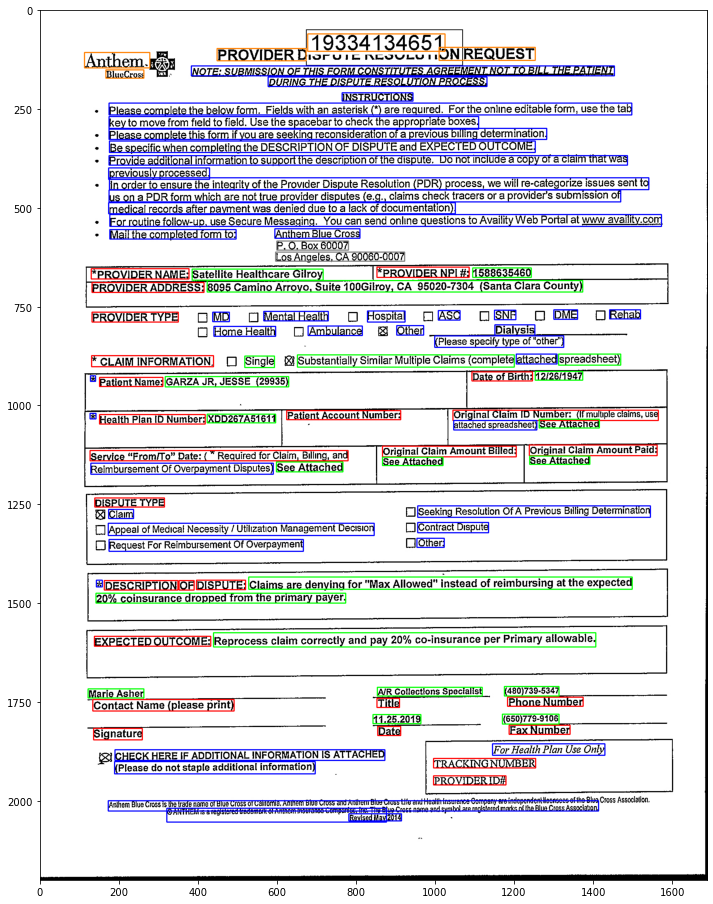

In [14]:
"""I am modifying the data_word to link all those which are a single entity.
for that I am considering two things,the shortest distance must be less than a 30, they must be on the
same horizontal line and their labels must be complementing """
for i in range(len(data_word)):
    if data_word.iloc[i]['x1']!=-1:
        start_yi = data_word.iloc[i]['y1']
        end_xi = data_word.iloc[i]['x2']
        end_yi = data_word.iloc[i]['y2']
        w_i = end_yi - start_yi
        tag_i = data_word.iloc[i]['label'] 
        if tag_i[0]=='B' or tag_i=='other':
            flag=True
            j=i+1
            while(flag and j<len(data_word)):
                start_xj = data_word.iloc[j]['x1']
                end_xj = data_word.iloc[j]['x2']
                start_yj = data_word.iloc[j]['y1']
                end_yj = data_word.iloc[j]['y2']
                w_j = end_yj - start_yj
                diff = start_xj-end_xi
                int_maxi = max(start_yi,start_yj)
                int_mini = min(end_yi,end_yj)
                w = int_mini - int_maxi
                tag_j = data_word.iloc[j]['label'] 
                if(diff<55 and (tag_i=='other' or tag_j[0]=='E' or tag_j[0]=='I')and (w>(0.2*w_i) or w>(0.2*w_j)) and tag_j[2:]==tag_i[2:]):
                    data_word.at[i,'text']=data_word.iloc[i]['text']+" "+data_word.iloc[j]['text']
                    data_word.at[i,'y1']=min(start_yi,start_yj)
                    data_word.at[i,'y2']=max(end_yi,end_yj)
                    data_word.at[i,'x2']= end_xj
                    data_word.at[j,'x1']= -1
                    end_xi=end_xj
                if(tag_j[0]=='E'or tag_j[0]=='B' or start_yj>end_yi+20):
                    flag=False
                j+=1
                
data_word=data_word[data_word['x1']>0].reset_index(drop=True)
for j in range(len(data_word)):
    labelling=data_word.iloc[j]['label']
    if(labelling!='other'):
        data_word.at[j,'label']=labelling[2:]

label2color = {'question':(255,0,0), 'answer':(0,255,0), 'header':(255, 128, 0), 'other':(0,0,255),
               'other (address)': (128,128,128)}
img= image.copy()
for i in range(len(data_word)):
    startX = data_word.iloc[i]['x1']
    startY = data_word.iloc[i]['y1']
    endX = data_word.iloc[i]['x2']
    endY = data_word.iloc[i]['y2']
    cv2.rectangle(img,(startX,startY),(endX,endY),label2color[data_word.iloc[i]['label'].lower()],2)
plt.imshow(img)
plt.show()

In [15]:
for i in range(len(data_word)):
    if data_word.iloc[i]['x1']!=-1:   
        start_xi = data_word.iloc[i]['x1']
        end_xi=data_word.iloc[i]['x2']
        label=data_word.iloc[i]['label']
        w_i=end_xi-start_xi
        end_yi= data_word.iloc[i]['y2']
        if w_i>0.4*W and label=="ANSWER":
            flag=True
            j=i+1
            while(flag and j<len(data_word)):
                start_xj = data_word.iloc[j]['x1']
                end_xj = data_word.iloc[j]['x2']
                start_yj = data_word.iloc[j]['y1']
                end_yj = data_word.iloc[j]['y2']
                w_j = end_xj - start_xj
                diff = start_xj-end_xi
                int_maxi = max(start_xi,start_xj)
                int_mini = min(end_xi,end_xj)
                w = int_mini - int_maxi
                tag_j = data_word.iloc[j]['label']
                dist=start_yj-end_yi
                if dist<20 and tag_j=='ANSWER' and (w>(0.5*w_i) or w>(0.5*w_j)) :
                    data_word.at[i,'text']=data_word.iloc[i]['text']+" "+data_word.iloc[j]['text']
                    data_word.at[i,'y2']=max(end_yi,end_yj)
                    data_word.at[i,'x1']=min(start_xj,start_xi)
                    data_word.at[j,'x1']= -1
                    end_yi=end_yj
                    j+=1
                else:
                    flag=False
data_word=data_word[data_word['x1']>0].reset_index(drop=True)

<h1>
    Carrying out Neigborhood Analysis
</h1>

In [16]:
def manhattan(index1,index2):
    #takes as input two indices of the data_word dataframe
    #outputs the Manhattan distance between the centers of the two indices corresponding bboxes
    center_iX = (data_word.iloc[index1]['x1']+data_word.iloc[index1]['x2'])//2
    center_iY = (data_word.iloc[index1]['y1']+data_word.iloc[index1]['y2'])//2
    center_jX = (data_word.iloc[index2]['x1']+data_word.iloc[index2]['x2'])//2
    center_jY = (data_word.iloc[index2]['y1']+data_word.iloc[index2]['y2'])//2
    return abs(center_iY-center_jY)+abs(center_iX-center_jX)

def mod_manhattan(index1,index2):
    #takes as input two indices of the data_word dataframe
    #outputs the Manhattan distance between the centers of the two indices corresponding bboxes
    center_iX = (data_word.iloc[index1]['x1']+data_word.iloc[index1]['x2'])//2
    center_iY = (data_word.iloc[index1]['y1']+data_word.iloc[index1]['y2'])//2
    center_jX = (data_word.iloc[index2]['x1']+data_word.iloc[index2]['x2'])//2
    center_jY = (data_word.iloc[index2]['y1']+data_word.iloc[index2]['y2'])//2
    return 5*abs(center_iY-center_jY)+abs(center_iX-center_jX)

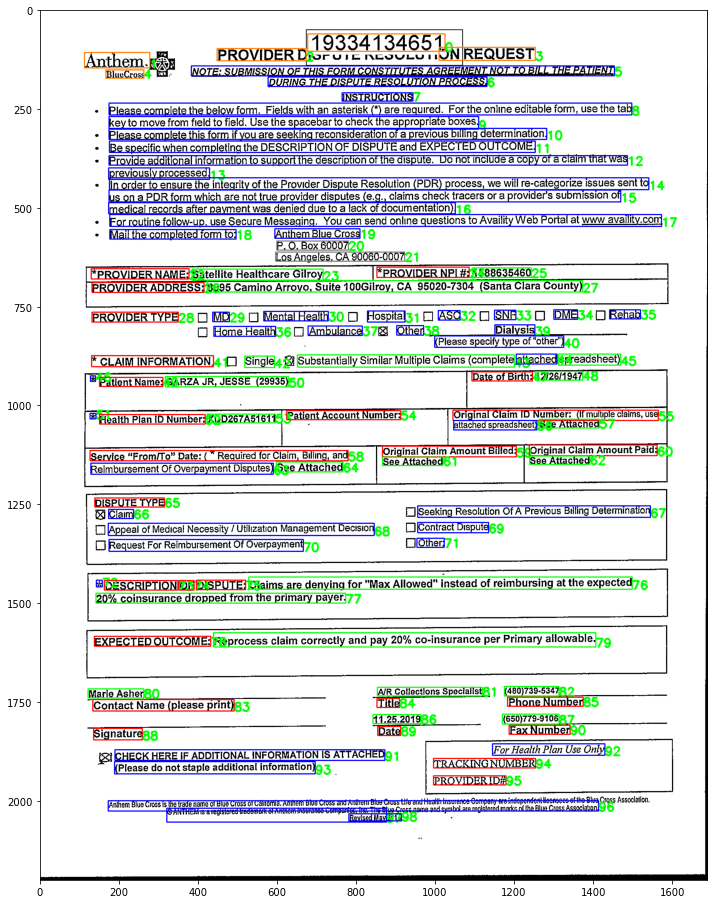

In [17]:
label2color = {'question':(255,0,0), 'answer':(0,255,0), 'header':(255, 128, 0), 'other':(0,0,255),
               'other (address)': (128,128,128)}
img= image.copy()
for i in range(len(data_word)):
    startX = data_word.iloc[i]['x1']
    startY = data_word.iloc[i]['y1']
    endX = data_word.iloc[i]['x2']
    endY = data_word.iloc[i]['y2']
    cv2.rectangle(img,(startX,startY),(endX,endY),label2color[data_word.iloc[i]['label'].lower()],2)
    cv2.putText(img,str(i),(endX,endY),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),3)
plt.imshow(img)
plt.show()

In [18]:
list_of_keys=[]
list_of_values=[]
for i in range(len(data_word)):
    labelling=data_word.iloc[i]['label']
    if(labelling=='ANSWER'):
        list_of_values.append(i)
    elif (labelling=='QUESTION'):
        list_of_keys.append(i)
    else:
        pass
distance_table=[]
i=0
for key in list_of_keys:
    distance_table.append([])
    for value in list_of_values:
        distance_table[i].append(mod_manhattan(key,value))
    i+=1

#distance_table(i,j) contains the Manhattan distance between key i and value j
cost_matrix=np.array(distance_table)
from scipy.optimize import linear_sum_assignment
row_ind, col_ind=linear_sum_assignment(cost_matrix)
key_value_pairs=[]
for i,j in zip(row_ind,col_ind):
    key_value_pairs.append((list_of_keys[i],list_of_values[j]))
key_value_=[]
for pair in key_value_pairs:
    key_value_.append((data_word.iloc[pair[0]]['text'],data_word.iloc[pair[1]]['text']))
key_value_=pd.DataFrame(key_value_,columns=['key','value'])
display(key_value_)


,key,value
0,* PROVIDER NAME:,Satellite Healthcare Gilroy
1,* PROVIDER NPI #:,1588635460
2,PROVIDER ADDRESS:,"8095 Camino Arroyo, Suite 100Gilroy, CA 95020-..."
3,PROVIDER TYPE,spreadsheet)
4,* CLAIM INFORMATION.,Single
5,Date of Birth:,12/26/1947
6,Patient Name:,"GARZA JR, JESSE (29935)"
7,Health Plan ID Number:,XDD267A51611
8,Patient Account Number:,Substantially Similar Multiple Claims (complete
9,"Original Claim ID Number: (If multiple claims,...",See Attached


In [39]:
key_value_.to_csv('C:\\Users\\AH31343\\anthem_documents\\dispute\\results\\27new_image.csv')

<h1>
    Setting up a UI
<h1>

In [19]:
import gradio as gr
input1 = gr.inputs.File()
input2 = gr.inputs.File()
iface = gr.Interface(fn=key_value,
                     inputs= [input1,input2], outputs=gr.outputs.Dataframe(headers=["key", "value"]))
iface.launch()

NameError: name 'key_value' is not defined